In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
frauds = pd.read_csv('Fraud.csv')
frauds.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
frauds.drop(['step', 'isFlaggedFraud'], axis=1, inplace=True)
frauds.head()


,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [4]:
frauds["nameOrig"].unique()

array(['C1231006815', 'C1666544295', 'C1305486145', ..., 'C1162922333',
       'C1685995037', 'C1280323807'], dtype=object)

In [5]:
frauds["nameOrig"] = frauds["nameOrig"].str[0]
frauds["nameDest"] = frauds["nameDest"].str[0]

In [6]:
frauds['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
frauds = pd.get_dummies(frauds, columns=['type'], drop_first=False)

In [8]:
frauds = frauds.replace({True: 1, False: 0})


In [9]:
frauds = frauds.replace({"M": 1, "C": 0})

In [10]:
frauds = frauds.dropna()

In [11]:
nameOrigs = frauds['nameOrig'].unique()
nameDests = frauds['nameDest'].unique()

len(nameOrigs), len(nameDests)

(1, 2)

In [12]:
positives = frauds[frauds['isFraud'] == 1]
negatives = frauds[frauds['isFraud'] == 0]

positives.shape, negatives.shape

((8213, 13), (6354407, 13))

#### **Simple Random Sampling to get evaluate Data**

In [13]:
positive_samples = positives.sample(n=100, random_state=42)  # Adjust 'n' as needed
negative_samples = negatives.sample(n=100, random_state=42)

positive_samples.to_csv('positive_samples.csv', index=False)
negative_samples.to_csv('negative_samples.csv', index=False)

positives = positives.drop(positive_samples.index)
negatives = negatives.drop(negative_samples.index)

In [14]:
## undersampling
negatives = negatives.sample(positives.shape[0])
negatives.shape

(8113, 13)

In [15]:
positives.shape, negatives.shape

((8113, 13), (8113, 13))

In [16]:
#Concatenating the two dataframes
data = pd.concat([positives, negatives])
data.shape

(16226, 13)

In [17]:
nameOrigs = data['nameOrig'].unique()
nameDests = data['nameDest'].unique()

len(nameOrigs), len(nameDests)

(1, 2)

In [18]:
# drop name orig 
data.drop(['nameOrig'], axis=1, inplace=True)
data.shape

(16226, 12)

#### **Corr Plot**

/home/aneaser/DataScience/ds/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


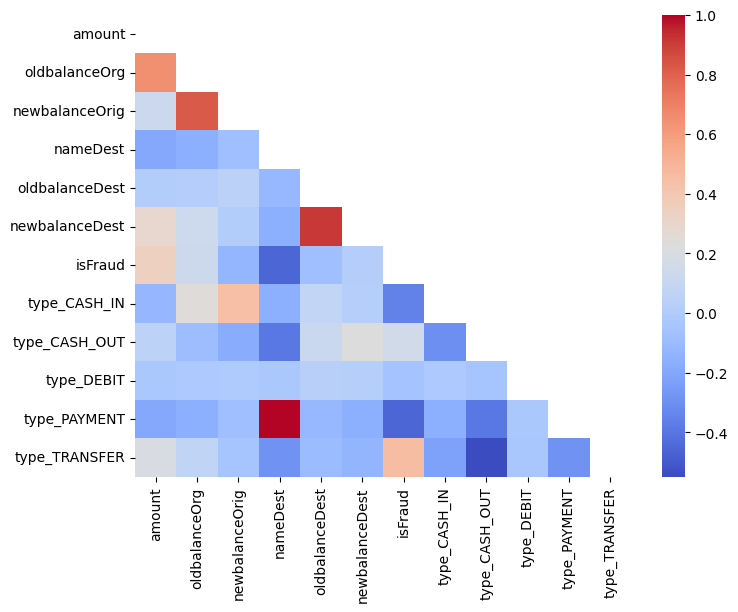

In [19]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

X = data.drop('isFraud', axis=1)
y = data['isFraud']

columns_to_scale = X.columns
scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
joblib.dump(scaler, 'scaler_weights.joblib')


['scaler_weights.joblib']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

99.35304990757857


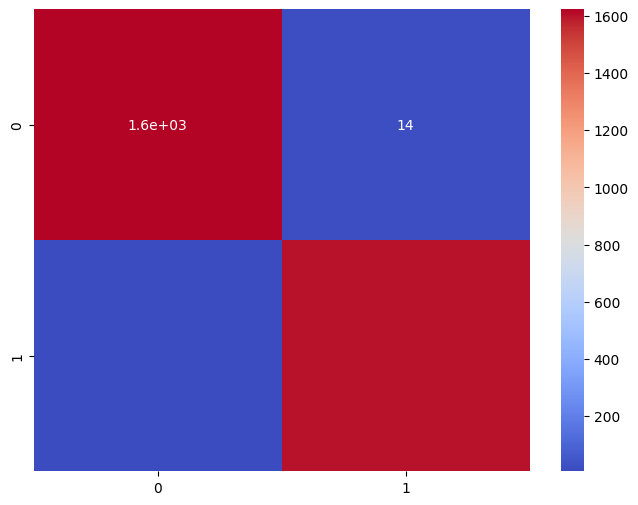

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1637
           1       0.99      1.00      0.99      1609

    accuracy                           0.99      3246
   macro avg       0.99      0.99      0.99      3246
weighted avg       0.99      0.99      0.99      3246



In [22]:
import xgboost as xgb

clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(accuracy * 100)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.show()

print(classification_report(y_test, y_pred))


In [23]:
# save the model to disk
joblib.dump(clf, 'xgboost_model.joblib')


['xgboost_model.joblib']